In [1]:
from helpers import *

2024-05-27 19:44:19.904081: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 19:44:19.956092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 19:44:19.956982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 19:44:20.724373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load datasets
df_articles, df_clicks, article_embeddings = load_dataset()

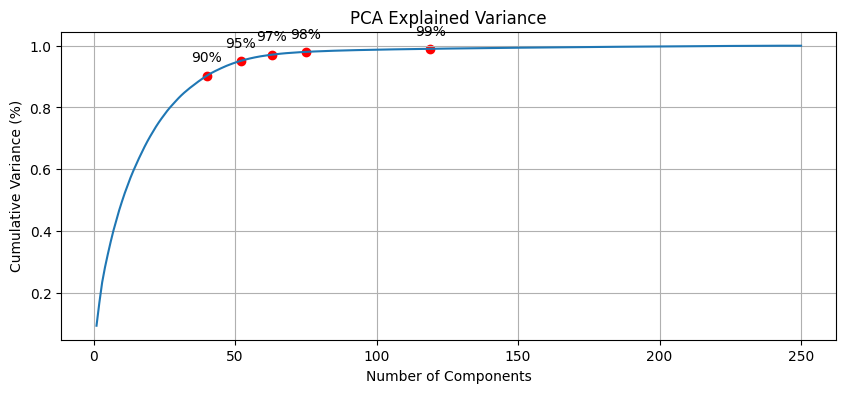

In [4]:
pca = PCA()
pca.fit(article_embeddings)

# Variance data
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
components = np.arange(len(cumulative_variance)) + 1

# Plotting
plt.figure(figsize=(10,4))
plt.plot(components, cumulative_variance, label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('PCA Explained Variance')

# Annotate specific variance percentages
variance_thresholds = [0.9, 0.95, 0.97, 0.98, 0.99]
for threshold in variance_thresholds:
    component_number = np.where(cumulative_variance >= threshold)[0][0]
    plt.scatter(component_number + 1, cumulative_variance[component_number], color='red')
    plt.annotate(f"{int(threshold*100)}%", (component_number + 1, cumulative_variance[component_number]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.show()

In [5]:
pca = PCA(n_components=0.98)
reduced_embeddings = pca.fit_transform(article_embeddings)
# reduced_embeddings = pca.fit_transform(article_embeddings)
print(reduced_embeddings.shape)
article_embeddings = reduced_embeddings
# cosine_sim_old = cosine_similarity(reduced_embeddings)


(364047, 75)


In [6]:
# preprocess data
df_articles = preprocessing_articles(df_articles)
df_clicks = preprocessing_clicks(df_clicks)
article_embeddings_df = pd.DataFrame(article_embeddings)
print("article_embeddings shape", article_embeddings_df.shape)
print("df_articles shape", df_articles.shape)

article_embeddings shape (364047, 75)
df_articles shape (364047, 5)


In [7]:
articles_clicked = df_clicks.click_article_id.value_counts().index
df_articles = df_articles.loc[articles_clicked]
article_embeddings_df = article_embeddings_df.loc[articles_clicked]

print("df_articles shape", df_articles.shape)
print("article_embeddings shape", article_embeddings_df.shape)

df_articles shape (46033, 5)
article_embeddings shape (46033, 75)


In [9]:
df_clicks = df_clicks.sample(n=500000)

In [10]:
def train_test_split_sessions(clicks_df, test_size=0.1, val_size=0.1, random_state=42):
    session_ids = clicks_df['session_id'].unique()
    train_sessions, test_sessions = train_test_split(session_ids, test_size=test_size, random_state=random_state)
    train_sessions, val_sessions = train_test_split(train_sessions, test_size=val_size, random_state=random_state)
    
    train_df = clicks_df[clicks_df['session_id'].isin(train_sessions)]
    val_df = clicks_df[clicks_df['session_id'].isin(val_sessions)]
    test_df = clicks_df[clicks_df['session_id'].isin(test_sessions)]
    all_df = clicks_df[clicks_df['session_id'].isin(session_ids)]
    
    return train_df, val_df, test_df, all_df
 

# Split the clicks dataframe
train_clicks_df, val_clicks_df, test_clicks_df, all_clicks_df = train_test_split_sessions(df_clicks)

print(f"Training clicks shape: {train_clicks_df.shape}")
print(f"Validation clicks shape: {val_clicks_df.shape}")
print(f"Testing clicks shape: {test_clicks_df.shape}")
print(f"All clicks shape: {all_clicks_df.shape}")

Training clicks shape: (405021, 14)
Validation clicks shape: (44918, 14)
Testing clicks shape: (50061, 14)
All clicks shape: (500000, 14)


In [10]:
#### Merging Articles Embeddings with Articles Metadata

# Merging with articles_metadata
# articles_merged_df = pd.merge(df_articles, article_embeddings_df, on='article_id')

In [11]:
tqdm.pandas()

def create_user_profiles(clicks_df, article_embeddings_df):
    user_profiles = clicks_df.groupby('user_id')['click_article_id'].apply(list).reset_index()
    embeddings_dict = article_embeddings_df.T.to_dict('list')
    
    user_profiles['user_embedding'] = user_profiles['click_article_id'].progress_apply(
        lambda x: np.mean([embeddings_dict[article] for article in x if article in embeddings_dict], axis=0)
    )
    
    return user_profiles

user_profiles_df_train = create_user_profiles(train_clicks_df, article_embeddings_df)
user_profiles_df_test = create_user_profiles(test_clicks_df, article_embeddings_df)
user_profiles_df_val = create_user_profiles(val_clicks_df, article_embeddings_df)
user_profiles_df_all = create_user_profiles(all_clicks_df, article_embeddings_df)

100%|██████████| 193547/193547 [00:05<00:00, 36310.66it/s]


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_content_based_model(input_dim):
    model = models.Sequential()
    # Input Layer
    model.add(layers.Input(shape=(input_dim,)))
    
    # Hidden Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    # Output Layer - Predicting the relevance score
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[ndcg_5, ndcg_10, mean_mrr, g_auc])
    return model

In [25]:
# Prepare data
def prepare_data(user_profiles_df_train, articles_df, articles_embeddings_df):
    X = []
    y = []
    
    embeddings_dict = articles_embeddings_df.T.to_dict('list')
    
    for i, user in tqdm(user_profiles_df_train.iterrows(), total=len(user_profiles_df_train)):
        # if i >= 50000:
        #     break
        
        user_embedding = user['user_embedding']
        clicked_articles = user['click_article_id']
        
        for article_id in clicked_articles:
            if article_id in embeddings_dict:
                article_embedding = embeddings_dict[article_id]
                combined_features = np.concatenate((user_embedding, article_embedding))
                X.append(combined_features)
                y.append(1) # Positive sample
        
        # Add some negative samples for training
        negative_samples = articles_df[~articles_df['article_id'].isin(clicked_articles)]['article_id'].sample(n=len(clicked_articles))
        
        for article_id in negative_samples:
            if article_id in embeddings_dict:
                article_embedding = embeddings_dict[article_id]
                combined_features = np.concatenate((user_embedding, article_embedding))
                X.append(combined_features)
                y.append(0) # Negative sample
                
    X = np.array(X)
    y = np.array(y)
    
    return X, y

In [26]:
X_train, y_train = prepare_data(user_profiles_df_train, df_articles, article_embeddings_df)


100%|██████████| 171191/171191 [07:48<00:00, 365.15it/s]


In [27]:
X_val, y_val = prepare_data(user_profiles_df_val, df_articles, article_embeddings_df)


100%|██████████| 32219/32219 [01:24<00:00, 379.77it/s]


In [28]:
def mrr(labels, predictions):
    if len(labels) != len(predictions):
        raise ValueError("Length of labels and predictions must be equal")

    # Combine labels and predictions, then sort by prediction score in descending order
    combined = list(zip(labels, predictions))
    combined_sorted = sorted(combined, key=lambda x: x[1], reverse=True)

    # Identify the rank position of the first relevant item (label == 1)
    for idx, (label, _) in enumerate(combined_sorted):
        if label == 1:
            return 1.0 / (idx + 1)

    # If no relevant item is found, return 0
    return 0.0

In [29]:
# Assuming article_embeddings's second dimension size is 250
input_dim = X_train.shape[1]
content_based_model = create_content_based_model(input_dim)

content_based_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               19328     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 27649 (108.00 KB)
Trainable params: 27649 (108.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
X_train

array([[ 2.32049155e+00, -1.25328517e+00,  7.35686064e-01, ...,
         1.71045452e-01, -1.51355723e-02, -2.29496226e-01],
       [ 2.32049155e+00, -1.25328517e+00,  7.35686064e-01, ...,
         4.92660031e-02,  4.82751951e-02, -1.59218803e-01],
       [ 1.39790213e+00, -3.29045630e+00, -3.48560035e-01, ...,
         9.80196148e-02,  2.10872948e-01, -1.17668130e-01],
       ...,
       [ 4.47421968e-01, -3.43003321e+00, -4.69363928e-01, ...,
        -6.26868784e-01, -3.69528830e-01, -2.41982914e-03],
       [ 3.22830510e+00,  9.02514279e-01,  3.91235471e-01, ...,
         1.97640762e-01, -1.41209409e-01, -1.02868520e-01],
       [ 3.22830510e+00,  9.02514279e-01,  3.91235471e-01, ...,
         1.22003101e-01,  2.37923965e-01,  9.87219736e-02]])

In [31]:
class CustomMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"\n\nEpoch {epoch+1}:", end=" ")
        for key, value in logs.items():
            print(f"\n- {key}: {value:.4f}", end=", ")
        print("\n")

# Using the custom callback
custom_metrics_callback = CustomMetricsCallback()
# Train the model
history = content_based_model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[custom_metrics_callback]
)

Epoch 1/10
25308/25314 [============================>.] - ETA: 0s - loss: 0.1513 - ndcg_5: 0.5053 - ndcg_10: 0.5053 - mean_mrr: 0.0641 - g_auc: 0.9840

Epoch 1: 
- loss: 0.1513, 
- ndcg_5: 0.5053, 
- ndcg_10: 0.5053, 
- mean_mrr: 0.0641, 
- g_auc: 0.9840, 
- val_loss: 0.0284, 
- val_ndcg_5: 0.7774, 
- val_ndcg_10: 0.7774, 
- val_mean_mrr: 0.0986, 
- val_g_auc: 0.9991, 

25314/25314 [==============================] - 124s 5ms/step - loss: 0.1513 - ndcg_5: 0.5053 - ndcg_10: 0.5053 - mean_mrr: 0.0641 - g_auc: 0.9840 - val_loss: 0.0284 - val_ndcg_5: 0.7774 - val_ndcg_10: 0.7774 - val_mean_mrr: 0.0986 - val_g_auc: 0.9991
Epoch 2/10
25309/25314 [============================>.] - ETA: 0s - loss: 0.1072 - ndcg_5: 0.4993 - ndcg_10: 0.4993 - mean_mrr: 0.0633 - g_auc: 0.9930

Epoch 2: 
- loss: 0.1072, 
- ndcg_5: 0.4994, 
- ndcg_10: 0.4994, 
- mean_mrr: 0.0633, 
- g_auc: 0.9930, 
- val_loss: 0.0229, 
- val_ndcg_5: 0.7774, 
- val_ndcg_10: 0.7774, 
- val_mean_mrr: 0.0986, 
- val_g_auc: 0.9993, 

253

In [102]:
embeddings_dict = article_embeddings_df.T.to_dict('list')
model = content_based_model
articles_df = df_articles

In [130]:
from joblib import Parallel, delayed
import numpy as np
from sklearn.metrics import roc_auc_score

from concurrent.futures import ThreadPoolExecutor

def process_user_wrapper(args):
    return process_user(*args)

def process_user(user, k):
    print("HELLO")
    user_embedding = user['user_embedding']
    user_id = user['user_id']
    clicked_articles = set(user['click_article_id'])

    all_embeddings = []
    article_ids = [article_id for article_id in articles_df['article_id'] if article_id in embeddings_dict]
    all_embeddings = [np.concatenate((user_embedding, embeddings_dict[article_id])).reshape(1, -1) for article_id in article_ids]
    
    all_embeddings = np.vstack(all_embeddings)
    
    scores = model.predict(all_embeddings, verbose=1).flatten()
    print("CCCC")
    
    true_labels = np.array([1 if article_id in clicked_articles else 0 for article_id in article_ids])
    print("DDDD")

    precisions.append(precision_at_k(true_labels, scores, k))
    recalls.append(recall_at_k(true_labels, scores, k))
    mrrs.append(mrr(true_labels, scores))
    ndcgs.append(ndcg_at_k(true_labels, scores, k))
    
    all_true_labels.extend(true_labels)
    all_scores.extend(scores)
    print("AAAA")
    
    return true

def evaluate_model_optimized(model, user_profiles_df_train, articles_df, articles_embeddings_df, k=10, num_users=2000):
    sampled_user_profiles_df = user_profiles_df_train.sample(n=num_users, random_state=42)

    args = [(user, k) for _, user in sampled_user_profiles_df.iterrows()]
    print(args)
    
    with ThreadPoolExecutor() as executor:
           executor.map(lambda x: process_user(*x), args)

    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)
    avg_mrr = np.mean(mrrs)
    avg_ndcg = np.mean(ndcgs)
    g_auc = roc_auc_score(all_true_labels, all_scores)

    return avg_ndcg, avg_mrr, avg_precision, avg_recall, g_auc

In [133]:
%%time
# ndcg_score, mrr_score, auc_score, y_pred = evaluate_model_on_test_data(content_based_model, X_test, y_test)
# print(f"NDCG@10: {ndcg_score:.4f}, MRR: {mrr_score:.4f}, AUC: {auc_score:.4f}")
# Evaluation
# ndcg_score, mrr_score, g_auc_score, y_true, y_pred, user_ids = evaluate_model_optimized(content_based_model, user_profiles_df_test, df_articles, article_embeddings_df, k=10, num_users=len(user_profiles_df_test))
avg_ndcg, avg_mrr, avg_precision, avg_recall, g_auc = evaluate_model_optimized(content_based_model, user_profiles_df_test, df_articles, article_embeddings_df, k=10, num_users=50)
print(f"NDCG@10: {avg_ndcg:.4f}, MRR: {avg_mrr:.4f}, precision: {avg_precision:.4f}, recall: {avg_recall:.4f}, g_auc: {g_auc:.4f}")


NDCG@10: 0.3124, MRR: 0.3869, precision: 0.1253, precision: 0.1400, recall: 0.4244, g_auc: 0.9683
CPU times: user 1h 26min 37s, sys: 19min 5s, total: 1h 45min 43s
Wall time: 56min 36s


In [35]:
def infer_top_k_articles(user_id, user_profiles_df, df_articles, article_embeddings_df, model, k=5):
    tmp_df_articles = df_articles.copy()
    # Retrieve the user's embedding
    user_profile = user_profiles_df[user_profiles_df['user_id'] == user_id].iloc[0]
    
    if user_profile.empty:
        raise ValueError("User ID not found in the user profiles.")

    user_embedding = user_profile['user_embedding']

    # Get all articles embeddings
    embeddings_dict = article_embeddings_df.T.to_dict('list')
    
    article_ids = []
    combined_features_list = []
    
    for article_id, article_embedding in embeddings_dict.items():
        article_ids.append(article_id)
        combined_features = np.concatenate((user_embedding, article_embedding)).reshape(1, -1)
        combined_features_list.append(combined_features)

    all_embeddings = np.vstack(combined_features_list)
    
    # Predict relevance scores using the trained model
    scores = model.predict(all_embeddings, verbose=0).flatten()

    print(user_profile["click_article_id"])
    # Add scores to dataframe
    tmp_df_articles['score'] = tmp_df_articles['article_id'].map(dict(zip(article_ids, scores)))
    tmp_df_articles = tmp_df_articles.sort_values(by='score', ascending=False)

    top_articles = tmp_df_articles.copy()[["article_id","category_id","score"]]
    user_article_clicked = top_articles[top_articles['article_id'].isin(user_profile["click_article_id"])].reset_index(drop=True)

    top_articles = top_articles[~top_articles['article_id'].isin(user_profile["click_article_id"])]

    # Rank articles based on scores
    top_k_indices = np.argsort(scores)[-k:][::-1]
    top_k_article_ids = [article_ids[i] for i in top_k_indices]
    
    # Rank articles based on scores (worst)
    bottom_k_indices = np.argsort(scores)[:k]
    bottom_k_article_ids = [article_ids[i] for i in bottom_k_indices]

    # Fetch top K articles metadata
    top_k_articles = top_articles[top_articles['article_id'].isin(top_k_article_ids)].reset_index(drop=True)
    bottom_k_article_ids = top_articles[top_articles['article_id'].isin(bottom_k_article_ids)].reset_index(drop=True)
    bottom_k_article_ids = bottom_k_article_ids.sort_values(by='score', ascending=True)
    
    # Display the top K articles usi
    return top_k_articles, bottom_k_article_ids, user_article_clicked

In [36]:
user_profiles_df_train

,user_id,click_article_id,user_embedding
0,1,[205973],"[2.3204915523529053, -1.2532851696014404, 0.73..."
1,3,[235132],"[1.3979021310806274, -3.2904562950134277, -0.3..."
2,4,[336499],"[2.248338222503662, 1.8892749547958374, -2.206..."
3,5,"[62631, 283776, 207122, 348117, 57442, 161801,...","[1.4540444078544776, 0.152463768919309, -0.974..."
4,6,"[234006, 166283, 156560, 160474]","[2.6375052630901337, -0.768208172172308, 0.569..."
...,...,...,...
171186,322881,"[342473, 277107]","[-0.9968196153640747, 3.328067898750305, -3.24..."
171187,322885,[234481],"[0.44742196798324585, -3.4300332069396973, -0...."
171188,322888,[50644],"[1.3372761011123657, -0.15394482016563416, 0.7..."
171189,322891,[234481],"[0.44742196798324585, -3.4300332069396973, -0...."


In [42]:
user_id=3
user_id=4
top_k_articles, bottom_k_article_ids, user_article_clicked = infer_top_k_articles(user_id, user_profiles_df_all, df_articles, article_embeddings_df, content_based_model, k=50)

[336499, 63307]


In [43]:
user_article_clicked

,article_id,category_id,score
0,336499,437,0.999849
1,63307,132,0.999737


In [44]:
top_k_articles

,article_id,category_id,score
0,63308,132,0.997510
1,63295,132,0.997350
2,336254,437,0.993286
3,63294,132,0.987549
4,336539,437,0.985598
5,63304,132,0.984523
6,63298,132,0.973308
7,108845,230,0.957415
8,336877,437,0.949380
9,337442,437,0.936284


In [40]:
bottom_k_article_ids

,article_id,category_id,score
4,133749,255,2.025254e-17
3,316273,431,2.380967e-17
2,306617,430,2.695469e-17
1,317774,433,2.876139e-17
0,318340,433,5.612870e-17


In [45]:
content_based_model.save('./input/content-based-reduced.h5')

/home/ubuntu/test/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [134]:

user_profiles_df_test.to_pickle("./input/user_profiles_df_test-reduced.pkl")

In [46]:
# Save DataFrames to disk


user_profiles_df_all.to_pickle("./input/user_profiles_df_all-reduced.pkl")
df_articles.to_pickle("./input/df_articles-reduced.pkl")
article_embeddings_df.to_pickle("./input/article_embeddings_df-reduced.pkl")

In [ ]:
article_embeddings_df.shape

In [ ]:
def infer_all_articles_scores(user_id, df, df_articles, article_embeddings_df, model):
    # Retrieve the user's embedding
    user_profile = df[df['user_id'] == user_id].iloc[0]
    
    if user_profile.empty:
        raise ValueError("User ID not found in the user profiles.")

    user_embedding = user_profile['user_embedding']

    # Get all articles embeddings
    embeddings_dict = article_embeddings_df.T.to_dict('list')
    
    article_ids = list(embeddings_dict.keys())
    combined_features_list = [np.concatenate((user_embedding, article_embedding)).reshape(1, -1) 
                              for article_embedding in embeddings_dict.values()]

    all_embeddings = np.vstack(combined_features_list)
    
    # Predict relevance scores using the trained model
    scores = model.predict(all_embeddings, verbose=0).flatten()

    # Create a dataframe with article IDs, category IDs, and scores
    article_scores_df = df_articles[['article_id', 'category_id']].copy()
    article_scores_df['score'] = article_scores_df['article_id'].map(dict(zip(article_ids, scores)))
    
    # Remove any unwanted header rows if present
    # article_scores_df.columns = article_scores_df.columns.droplevel(0)
    article_scores_df.reset_index(drop=True, inplace=True)
    return article_scores_df

In [ ]:
articles_scores = infer_all_articles_scores(user_id, user_profiles_df_all, df_articles, article_embeddings_df, content_based_model)
articles_scores